In [133]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 242942527 Analysis (EA)

Meant to replace the entry for EPIC 210666756

VSX Entry: https://www.aavso.org/vsx/index.php?view=detail.top&oid=625480

3 stars in questions.
Star A, or EPIC 210666756, is the one identified in VSX, with ready lightcurves from K2 and TESS: 

| Star | K2             | TESS          | Gaia                       | GMag | Separation |
| ---- | -------------- | ------------- | -------------------------- | ---- | ---------- |
| A    | EPIC 210666756 | TIC 242942524 | Gaia DR3 49835540624946304 | 12.9 | 0"         |
| B    |                | TIC 640392006 | Gaia DR3 49835540624946560 | 15.3 | 2.4"       |
| C    |                | TIC 242942527 | Gaia DR3 49835540624946176 | 14.9 | 8.0"       |

TIC 242942527 is the most likely source of the variability, based on centroid offset analysis from K2 and TESS


## Centroid Offset Analysis from K2

Vetting result the in-eclipse centroid is near star C.
- report at: https://keplertcert.seti.org/DAVE/K2/Output/210666756/
- the [record](https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ65714c8e2e2349&-out.add=.&-source=J/AJ/157/124/table2&recno=5) from 2019AJ....157..124K


Left: Annotated result for brevity; Right: the original plot from Vetting report section [Centroid 1 Plots](https://keplertcert.seti.org/DAVE/K2/Output/210666756/#:~:text=Centroid%201%20Plots):

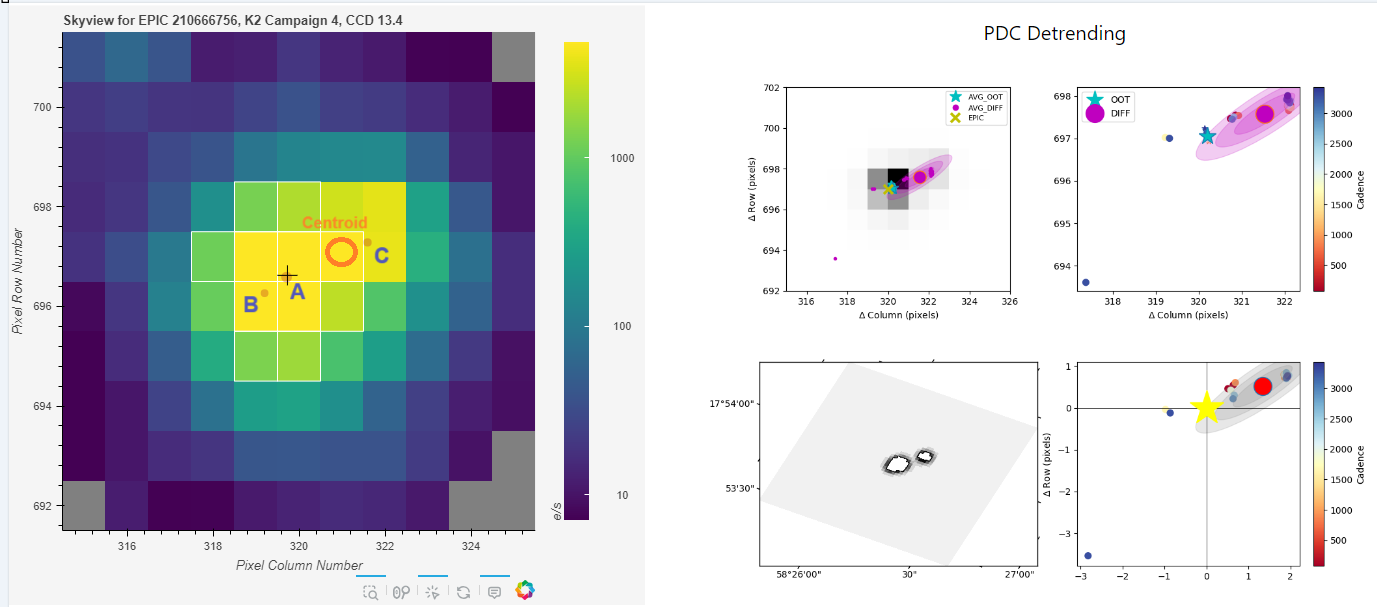



## Centroid Offset Analysis from TESS

TESS TCEs suggest similar offset, e.g. from the [TCE for sectors 42 - 44](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2021233042500-s0042-s0046-0000000242942524-00550_dvm.pdf), i.e., 2021 Aug 20 to Nov 06.

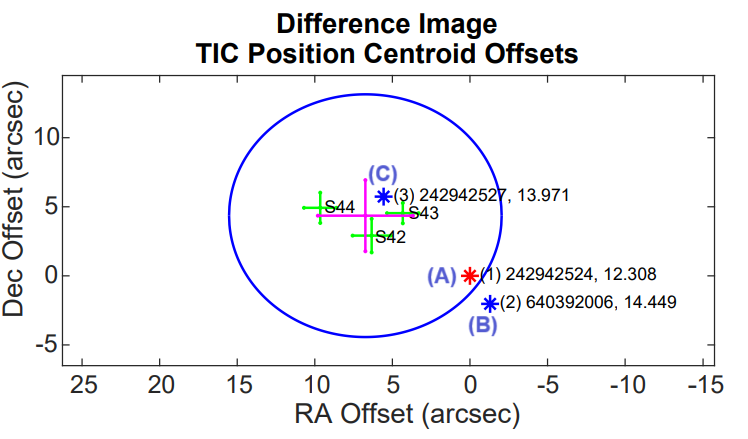


The TCE for more recent data suggests similar offset
- [TCE for sector 70](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2023263202030-s0070-s0070-0000000242942524-00809_dvm.pdf), 2023 Sep 20 to Oct 16
- [TCE for sector 71](https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2023289124029-s0071-s0071-0000000242942524-00816_dvm.pdf), 2023 Oct 16 to Nov 11

TESS Sector observation date for reference:  https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

In [134]:
display(HTML(lket.get_tic_meta_in_html(242942524, download_dir=lk_download_dir)))

Lightcurves from ZTF DR19: inconclusive. No variability shown in any of the targets.

---

## Gaia DR3 info (coordinate, etc.)

In [135]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(242942527)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(58.43745889297, 17.90046885354, unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=58.43745889297, dec=17.90046885354)
primary_name = "TIC 242942527"

flag,separation,RAJ2000,DEJ2000,RPmag,Gmag,BPmag,BP-RP,Teff,RUWE,sepsi,epsi,NSS,Plx,pmRA,pmDE,VarFlag,RV,e_RV,IPDfmp,Dup,Source,EpochPh,EpochRV
,arcsec,deg,deg,mag,mag,mag,mag,K,,,mas,,mas,mas / yr,mas / yr,,km / s,km / s,,,,,
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,uint8,float64,float64,float64,str13,float64,float32,int16,uint8,int64,uint8,uint8
!!! ✓,0.004,58.43745889297,17.90046885354,13.919,14.855,15.702,1.784,4179.0,2.385,39.8,0.369,0,3.2155,-18.445,-33.593,NOT_AVAILABLE,-46.34,4.67,0,0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=49835540624946176&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>49835540624946176,0,0
!,7.979,58.43583499481,17.89888155906,12.233,12.900,13.386,1.153,4813.8,0.872,3.81,0.055,0,3.2019,-18.560,-34.606,NOT_AVAILABLE,-39.70,1.50,0,0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=49835540624946304&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>49835540624946304,0,0
!!!,10.344,58.43545949308,17.89831718062,14.225,15.260,15.935,1.711,--,1.745,47.1,0.473,0,3.1451,-18.301,-34.406,NOT_AVAILABLE,-38.44,5.64,7,0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F

## Get K2 / TESS Data for the nearby star EPIC 210666756

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,K2 Campaign 04,2015,K2,1800,ktwo210666756,0.0,GO4007_GO4029_GO4033
1,K2 Campaign 04,2015,EVEREST,1800,ktwo210666756,0.0,--
2,K2 Campaign 04,2015,K2SC,1800,ktwo210666756,0.0,--
3,K2 Campaign 04,2015,K2SFF,1800,ktwo210666756,0.0,--
4,K2 Campaign 04,2015,K2VARCAT,1800,ktwo210666756,0.0,--


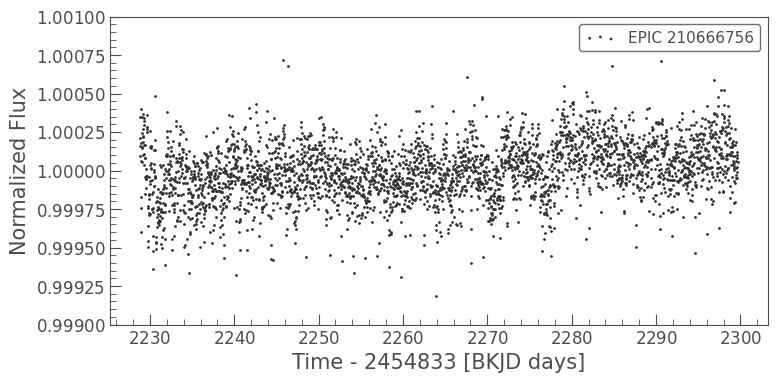

In [157]:
sr = lk.search_lightcurve("EPIC 210666756")
display(sr)

lc_k2 = sr[sr.author == "K2"].download()
ax = lc_k2.normalize().scatter();
ax.set_ylim(0.999, 1.001);

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 42,2021,SPOC,120,242942524,0.0,G04242
1,TESS Sector 43,2021,SPOC,120,242942524,0.0,G04242
2,TESS Sector 44,2021,SPOC,120,242942524,0.0,G04242
3,TESS Sector 70,2023,SPOC,120,242942524,0.0,G06058
4,TESS Sector 71,2023,SPOC,120,242942524,0.0,G06058


TESS flux origin: sap_flux


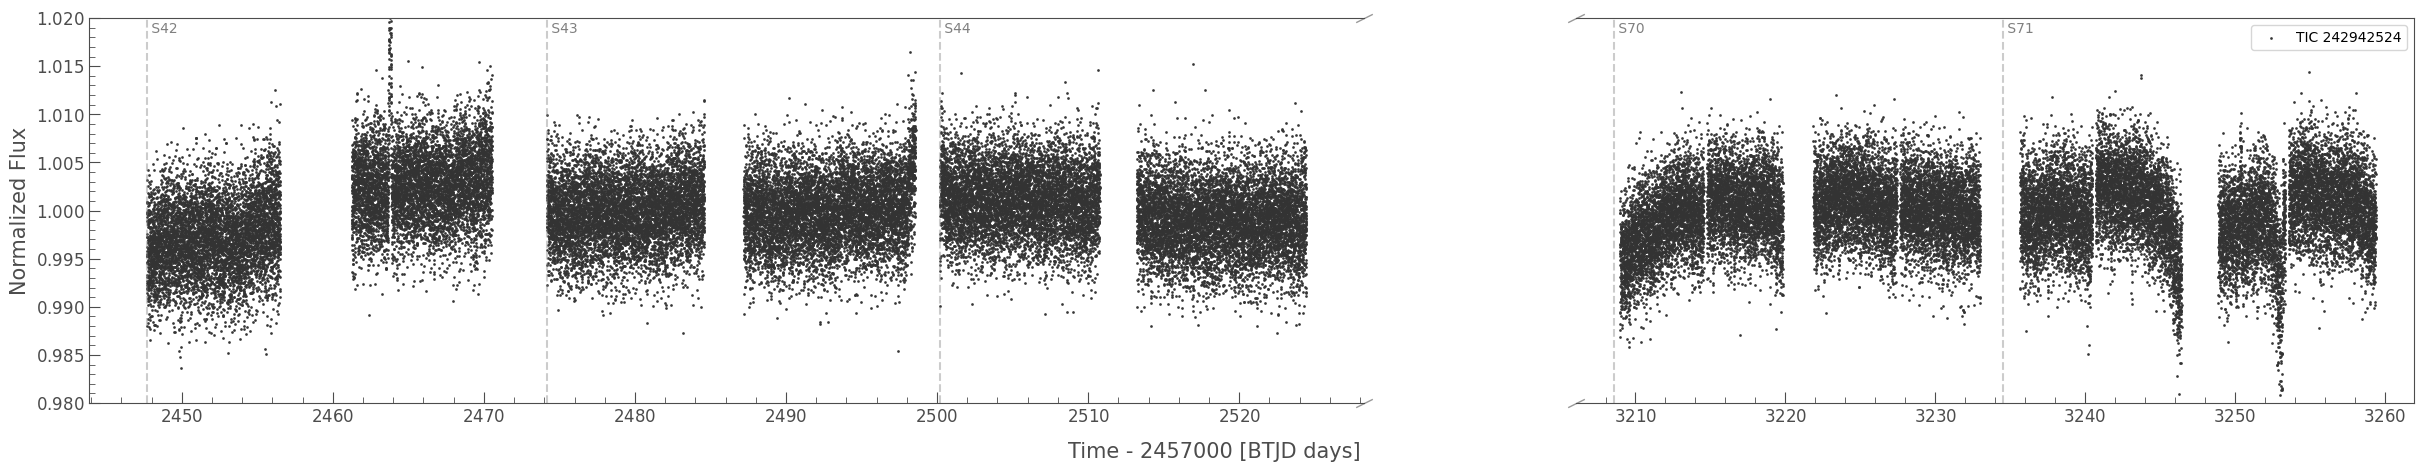

In [172]:
sr = lk.search_lightcurve("TIC242942524", cadence="short")
display(sr)

lcc_tess = sr.download_all()  # a collection of LCs
# Note: SAP_FLUX will be used as the basis for crowding correction, see crowding correction section below.
# Here, SAP_FLUX is also used to avoid any confusion.
# To keep the LC clean, problematic cadences (mostly due to scattered lights)
# are avoided by using `.remove_nans()` on PDCSAP_FLUX
#
# `lc_k2` above still uses PDCSAP_FLUX, because SAP_FLUX is not usable for K2.
# Furthermore, K2 data is not used for crowding correction anyway. So it's not critical to be in SAP_FLUX
lc_tess = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.remove_nans().select_flux("sap_flux").normalize())
axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);
[ax.set_ylim(0.98, 1.02) for ax in axs];
print("TESS flux origin:", lc_tess.flux_origin)

In [138]:
#
# Eclipse parameters
#

# epoch from s0042-s0046:TCE1 below, period from Sebatsian (based on TESS + K2)
epoch_time_btjd = 2448.5286
epoch_time_bkjd = Time(epoch_time_btjd, format="btjd").to_value("bkjd")
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough
period = 1.396455
duration_hr = 1.6  # based on TESS TCEs

Convert TESS / K2 data to be in HJD/UTC and magnitude

TESS # data points: 74909
K2 # data points: 3282


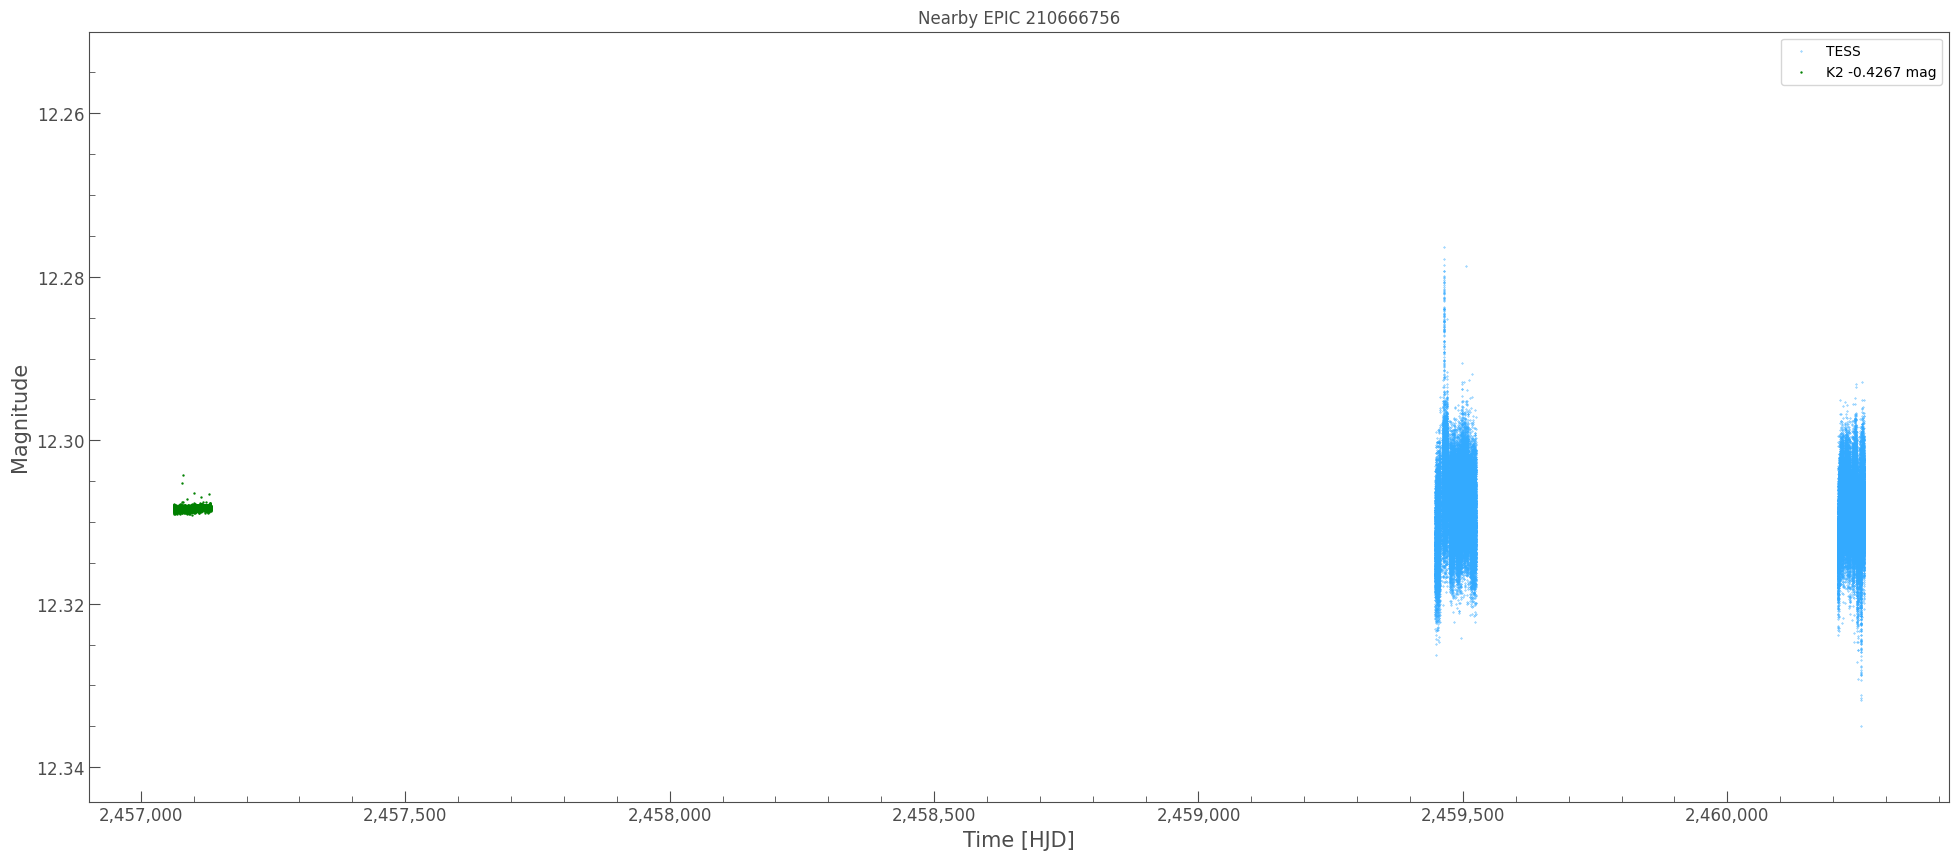

In [175]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
reload(lkem)
reload(lke)


lc_k2 = lke.convert_lc_time_to_hjd_utc(lc_k2, target_coord=target_coord, cache_dir=lk_download_dir)
lc_k2 = lke.to_flux_in_mag_by_normalization(lc_k2)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)

lc_combined_dict = lkem.combine_tess_n_k2(lc_tess, lc_k2)
for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_tess_n_k2(lc_combined_dict, figsize=(24, 10), target_name="Nearby EPIC 210666756");
ax.set_ylim(None, 12.25);

## Crowding correction (on TESS data)

- Use TESS data only as it has less spatial resolution. So the aperture of the contaminated lightcurve has proportionally more flux from the actual target.

In [2]:
sr_tpf = lk.search_targetpixelfile("TIC242942524")
display(sr_tpf)
tpf = sr_tpf[0].download();

tpf.interact_sky(notebook_url=notebook_url, aperture_mask="pipeline");

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 42,2021,SPOC,120,242942524,0.0,G04242
1,TESS Sector 43,2021,SPOC,120,242942524,0.0,G04242
2,TESS Sector 44,2021,SPOC,120,242942524,0.0,G04242
3,TESS Sector 70,2023,SPOC,120,242942524,0.0,G06058
4,TESS Sector 71,2023,SPOC,120,242942524,0.0,G06058
5,TESS Sector 42,2021,TESS-SPOC,600,242942524,0.0,N/A
6,TESS Sector 43,2021,TESS-SPOC,600,242942524,0.0,N/A
7,TESS Sector 44,2021,TESS-SPOC,600,242942524,0.0,N/A


The 3 stars in the TESS aperture

![skyview](https://i.gyazo.com/22d7a82f5c04ff29c524deea9cb4bb20.png)

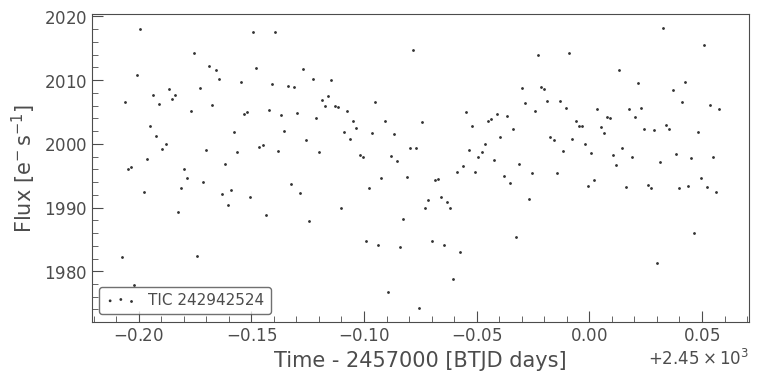

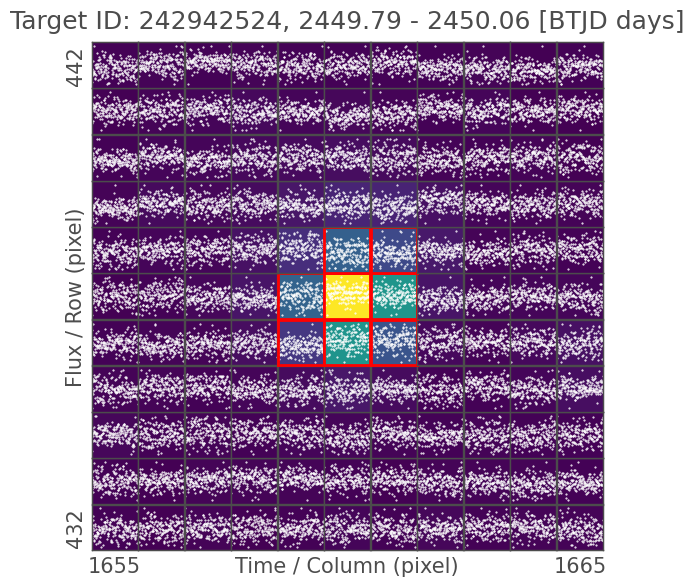

In [17]:
t0 = epoch_time_btjd  + period * 1  # choose a dip that is
tpf_trunc = lke.truncate(tpf,  t0 - duration_hr / 24 * 2, t0 + duration_hr / 24 * 2)
tpf_trunc.to_lightcurve().scatter();

pixel_size_inches, markersize = 0.6, 1
ax = tplt.lk_ax(figsize=(tpf_trunc.flux[0].shape[1] * pixel_size_inches, tpf_trunc.flux[0].shape[0] * pixel_size_inches))
tpf_trunc.plot_pixels(ax=ax, markersize=markersize, show_flux=True, aperture_mask="pipeline");

### Determine the relative flux of the target in the aperture, and construct crowding corrected Lightcurve

In [141]:
# The 3 TICs in the aperture

tics = [ 242942524,   # the TESS lc's target
        640392006,  # the other star
        242942527,  # the actual variability source to be reported
]

tic_rs = lket.catalog_info_of_tics(tics)
# 12.3083: Tmag of TIC 242942524, the brightest one with pre-built lightcurves in TESS / K2
tic_rs["Relative_Flux"] = 1 / 2.51 **(tic_rs["Tmag"] - 12.3083)

display(HTML("""Column Descriptions in:
<a href="https://outerspace.stsci.edu/display/TESS/TIC+v8.2+and+CTL+v8.xx+Data+Release+Notes" target="_tic_columns_doc">Data Release Notes</a> |
<a href="https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=IV/39" target="_tic_vizier" title="Vizier seems to have more complete information about various flag values.">Vizier table</a>
"""))
display(
    tic_rs['ID',
           'Tmag',
           'Relative_Flux',
           'Vmag',
           'VmagFlag',  # source of Vmag
           'GAIA', 'TWOMASS', 'disposition', 'duplicate_id',
          ]
)

ID,Tmag,Relative_Flux,Vmag,VmagFlag,GAIA,TWOMASS,disposition,duplicate_id
str9,float64,float64,float64,str5,str17,str16,str1,str1
640392006,14.449,0.13944998260416247,15.8058,gaia2,49835540624946560,--,--,--
242942527,13.971,0.21650229445481797,15.499,ucac4,49835540624946176,03534499+1754019,--,--
242942524,12.3083,1.0,13.132,ucac4,49835540624946304,03534460+1753560,--,--


0.15967254222287777


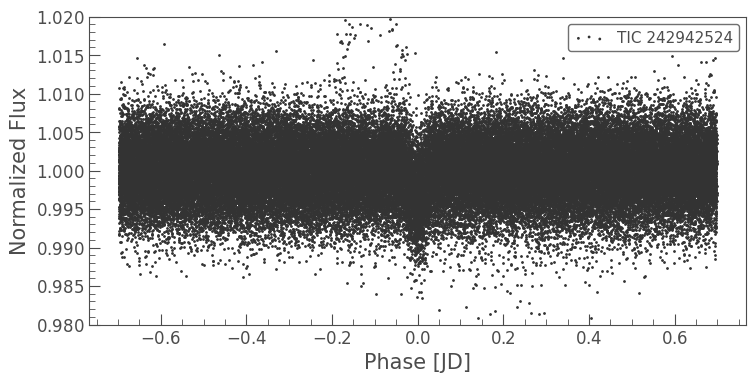

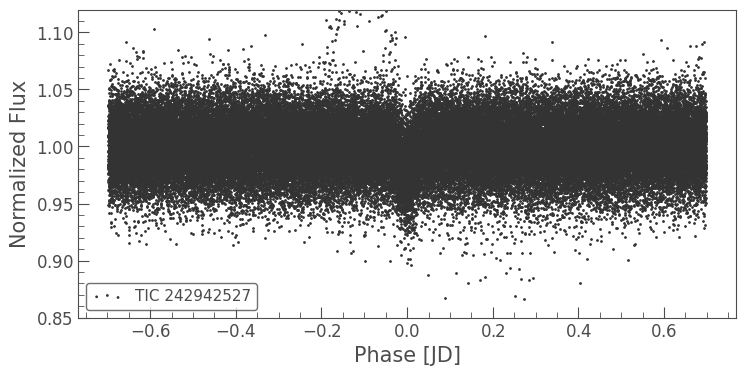

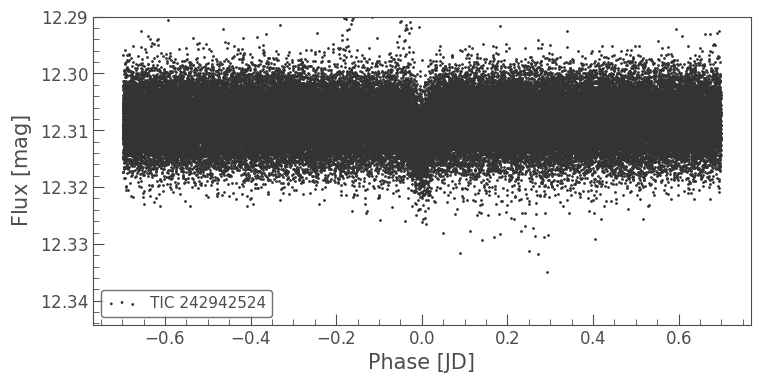

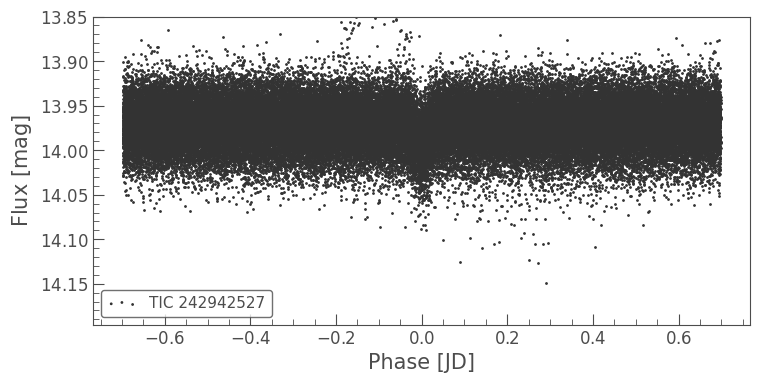

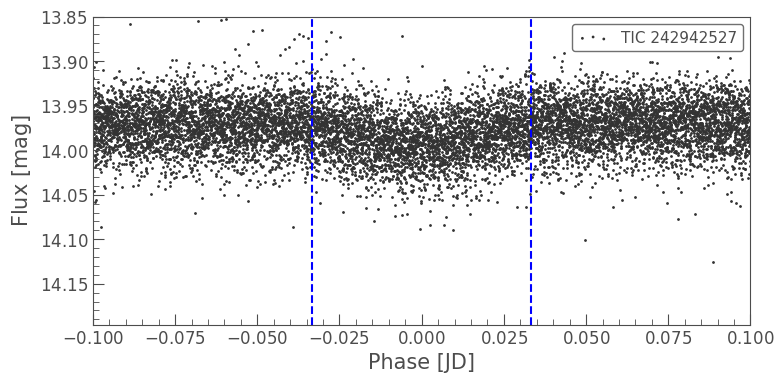

In [209]:
# estimate the ratio of the flux in the contaminated aperture that belongs to the target
# and construct a corrected lightcurve
target_flux_ratio_in_aperture = 0.2165 / (0.1394 + 0.2165 + 1)
print(target_flux_ratio_in_aperture)

# create a crowding corrected LC based on flux ratio in aperture (akin to CROWSAP in TESS)
def correct_crowding(lc, crowdsap, flfrcsap, normalize=True):
    # based on: https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowding.html
    median_flux = np.median(lc.flux)
    excess_flux = (1 - crowdsap) * median_flux
    flux_removed = lc.flux  - excess_flux  # note: a **constant** amount of flux is removed, so a dip would be proportionally deeper
    flux_corr = flux_removed / flfrcsap
    lc_corr = lk.LightCurve(time=lc.time, flux=flux_corr)
    lc_corr.meta.update(lc.meta)
    lc_corr.meta["CROWDSAP"] = crowdsap
    lc_corr.meta["FLFRCSAP"] = flfrcsap
    if normalize:
        lc_corr = lc_corr.normalize()
    return lc_corr

# Note: we use SAP_FLUX as the basis for crowding correction, but
# SAP_FLUX covers fair amount of problematic cadences (mostly due to scattered light)
# To make the lightcurve cleaner, the problematic cadences
# via `.remove_nans()` on PDCSAP_FLUX.
lc_tess_contaminated = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.remove_nans().select_flux("sap_flux").normalize())
lc_tess_contaminated_f = lc_tess_contaminated.fold(epoch_time=epoch_time_btjd, period=period)
ax = tplt.scatter(lc_tess_contaminated_f)
ax.set_ylim(0.98, 1.02);

lc_tess_target = correct_crowding(lc_tess_contaminated, target_flux_ratio_in_aperture, 1)
lc_tess_target.label = primary_name
lc_tess_target.meta['TESSMAG'] = 13.971
ax = lc_tess_target.fold(epoch_time=epoch_time_btjd, period=period).scatter();
ax.set_ylim(0.85, 1.12);

# Now convert them to magnitude

lc_tess_contaminated = lke.to_flux_in_mag_by_normalization(lc_tess_contaminated)
lc_tess_contaminated_f = lc_tess_contaminated.fold(epoch_time=epoch_time_btjd, period=period)
ax = tplt.scatter(lc_tess_contaminated_f);
ax.set_ylim(None, 12.29);


lc_tess_target = lke.to_flux_in_mag_by_normalization(lc_tess_target)
lc_tess_target_f = lc_tess_target.fold(epoch_time=epoch_time_btjd, period=period)
ax = tplt.scatter(lc_tess_target_f);
ax.set_ylim(None, 13.85);

# Zoom-in Show the duration
ax = tplt.scatter(lc_tess_target_f);
ax.set_ylim(None, 13.85);
ax.set_xlim(0 - 1.5 * duration_hr / 24, 0 + 1.5 * duration_hr / 24 );
ax.axvline(0 - duration_hr / 24 / 2, c="b", linestyle="--");
ax.axvline(0 + duration_hr / 24 / 2, c="b", linestyle="--");

In [177]:
# Depth of the contaminated LC
min_flux_sample = lc_tess_contaminated_f.truncate(0 - 1/24/60, 0 + 1/24/60).flux
min_flux_mag = np.nanmedian(min_flux_sample)
print(min_flux_mag, ", # data points:", len(min_flux_sample))

mag_diff_contaminated = (min_flux_mag - np.nanmedian(lc_tess_contaminated_f.flux)).value
print("Dip's depth, contaminated LC:", mag_diff_contaminated)

12.311943054199219 mag , # data points: 74
Dip's depth, contaminated LC: 0.00364304


In [178]:
min_flux_sample = lc_tess_target_f.truncate(0 - 1/24/60, 0 + 1/24/60).flux
min_flux_mag = np.nanmedian(min_flux_sample)
print(min_flux_mag, ", # data points:", len(min_flux_sample))

mag_diff_target = (min_flux_mag - np.nanmedian(lc_tess_target.flux)).value
print("Dip's depth, corrected:", mag_diff_target)

13.994022369384766 mag , # data points: 74
Dip's depth, corrected: 0.02302265


## Plots for VSX

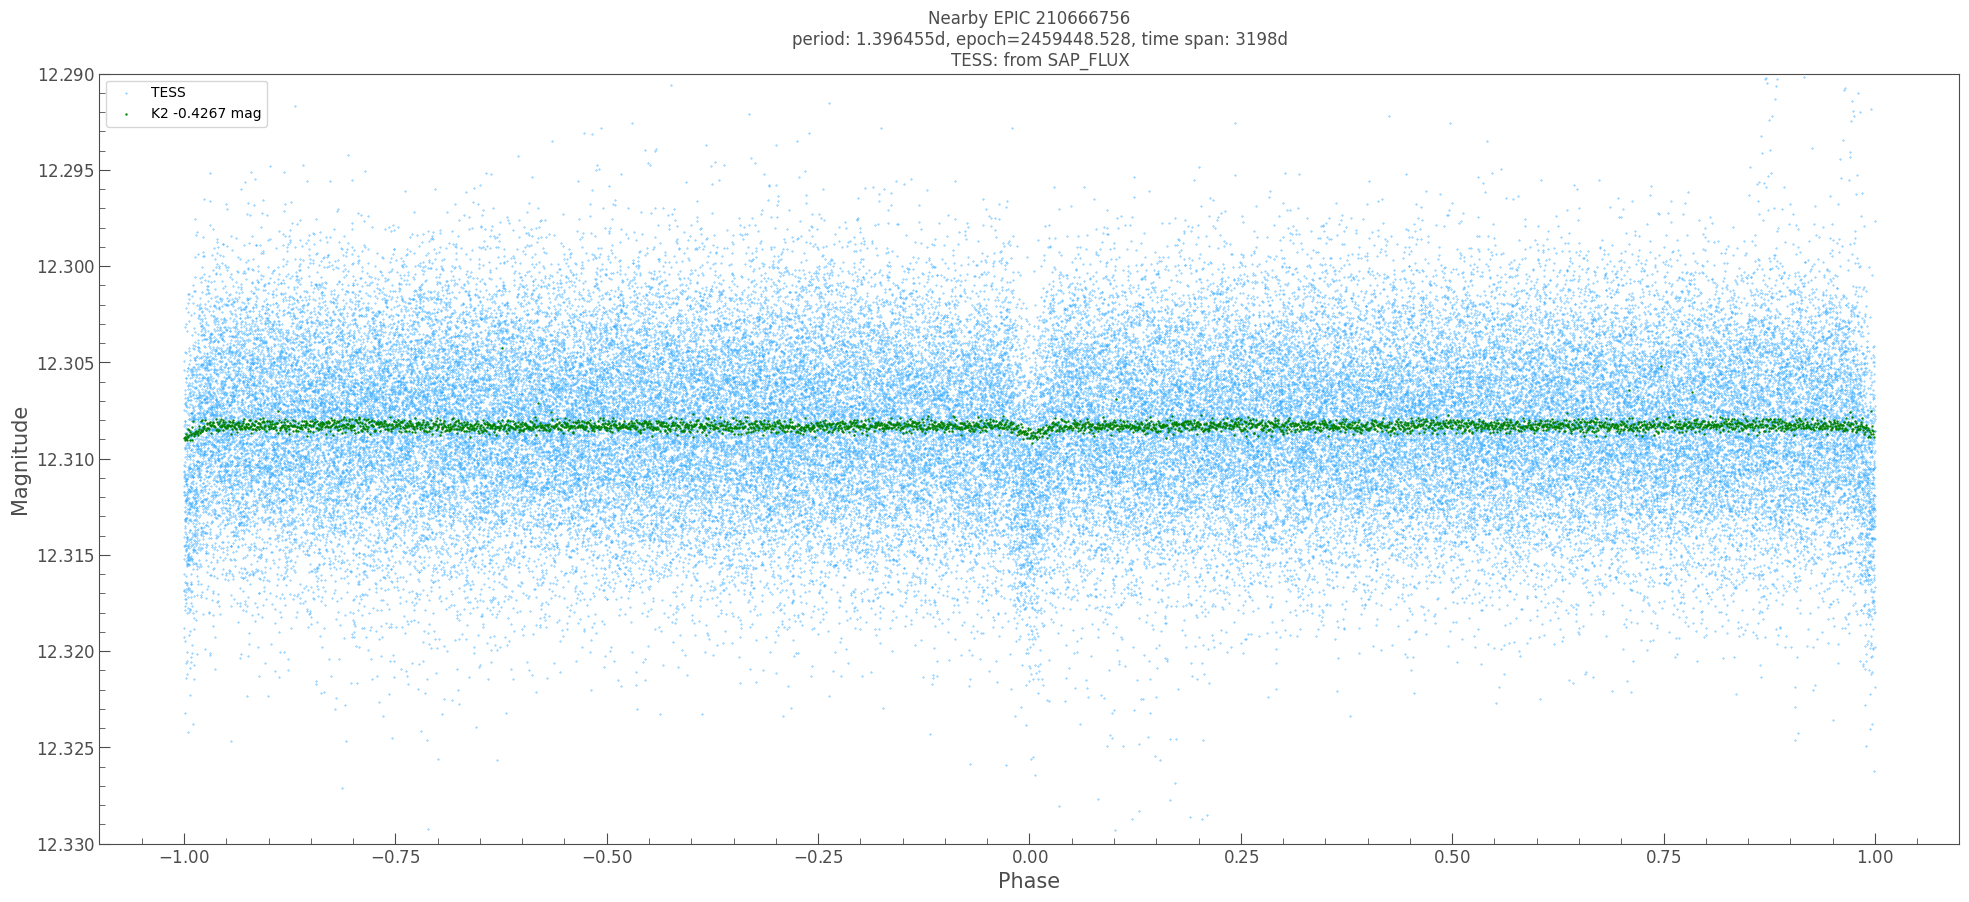

In [192]:
ax, lc_f_res = lkem.fold_n_plot_tess_n_k2(
    lc_combined_dict,
    period=period,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_coord=target_coord,
    figsize=(24, 10),
    target_name="Nearby EPIC 210666756", # This is the LC of the nearby star, not the target
);
ax.set_title(ax.get_title() + "TESS: from SAP_FLUX");
ax.set_ylim(12.33, 12.29);

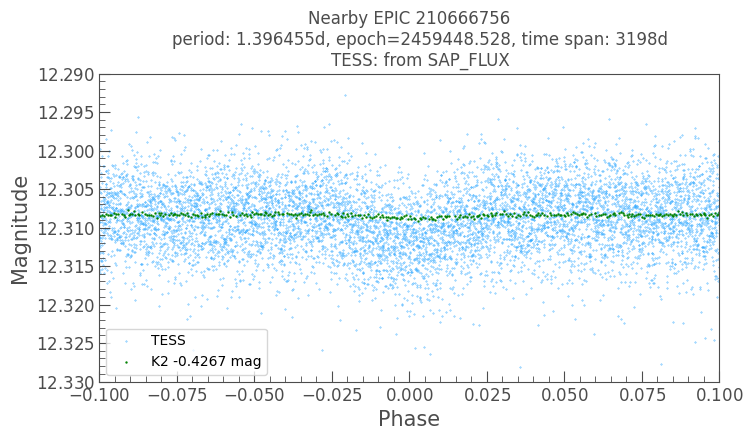

In [207]:
ax, lc_f_res = lkem.fold_n_plot_tess_n_k2(
    lc_combined_dict,
    period=period,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_coord=target_coord,
    figsize=(8, 4),
    target_name="Nearby EPIC 210666756", # This is the LC of the nearby star, not the target
);
ax.set_title(ax.get_title() + "TESS: from SAP_FLUX");
ax.set_ylim(12.33, 12.29);
ax.set_xlim(-0.1, 0.1);

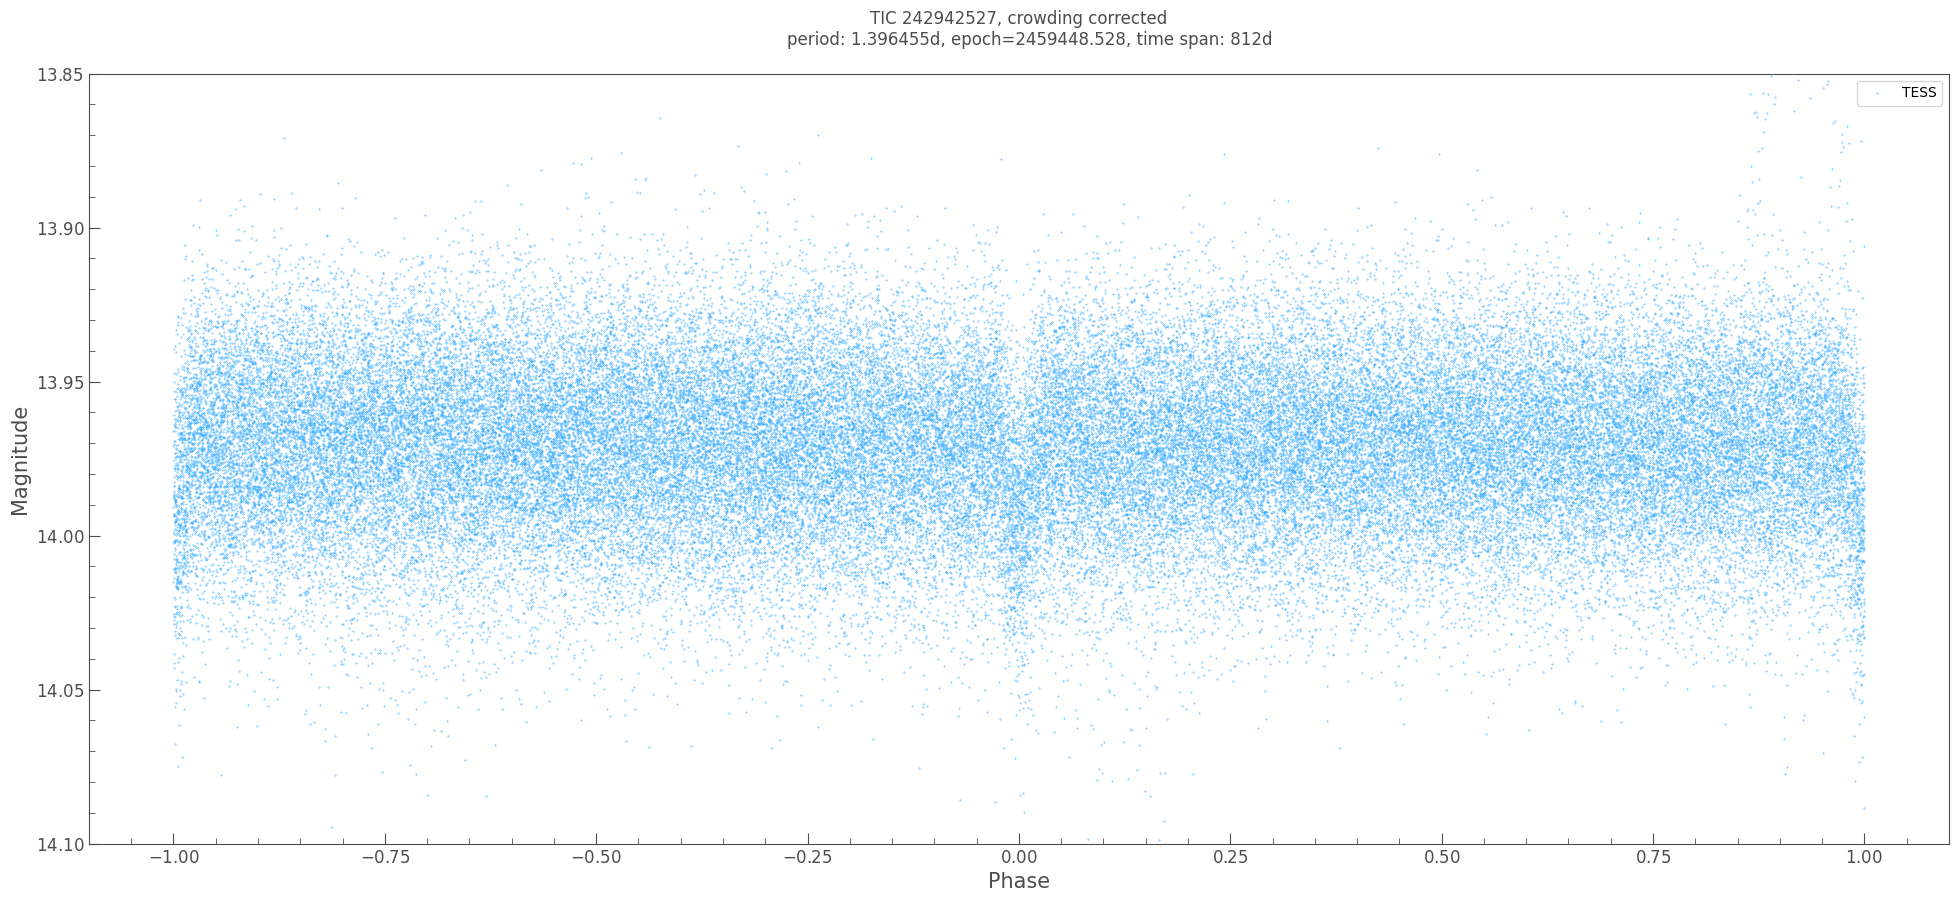

In [194]:
ax, lc_f_res = lkem.fold_n_plot_tess_n_k2(
    # the code expected LC in HJD
    dict(TESS=lke.convert_lc_time_to_hjd_utc(lc_tess_target, target_coord, cache_dir=lk_download_dir, cache_key="hjd_TIC_242942527_corrected.txt")),
    period=period,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_coord=target_coord,
    figsize=(24, 10),
    target_name="TIC 242942527, crowding corrected", # This is the LC of the target, with crowding correction
);
ax.set_ylim(14.10, 13.85);

## VSX Report Table

In [195]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [204]:
import bibs_utils
reload(bibs_utils)


other_names = "2MASS J03534499+1754019"  # 2MASSS in both TIC and Gaia DR3
# No GSC, https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/255/out
other_names += ",EPIC 210666756"  #  the nearby star with the contaminated lightcurve  in TESS / K2
# No need to re-add existing names # other_names = ",ASASSN-V J074356.31-602347.0,TYC 8911-718-1,WISEA J074356.30-602347.2" + other_names  # prepend existing other names in the VSX record

remarks = f"Nearby EPIC 210666756 / TIC 242942524 lightcurves from K2 / TESS are contaminated. The target is determined to be the source per 2019AJ....157..124K and TCE . Amplitude is based on crowding-corrected TIC 242942524. Contaminated amplitude: {mag_diff_contaminated:.3f} TESS (SAP_FLUX) ."
revision_comment = "Type, period, epoch, duration from TESS and K2. Amplitude from TESS. Spectral type and position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="K",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{lc_tess_target.TESSMAG:.2f}",
    Maximum_Magnitude_band="TESS",
    Minimum_Magnitude=f"{mag_diff_target:.3f}",
    Minimum_Magnitude_band="TESS",
    Minimum_Is_Amplitude=True,
    Period=period,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr / 24 / period:.0f}",
    Discoverer="",  #  The original entry https://www.aavso.org/vsx/index.php?view=detail.top&oid=625480 has no discoverer
    Remarks=remarks,
    Revision_Comment=revision_comment,
    # Centroid Offset references
    Reference1_Name=BIBS.K2_N,
    Reference1_Bib=BIBS.K2_B,
    Reference2_Name=BIBS.TESS_N,
    Reference2_Bib=BIBS.TESS_B,
    Reference11_Name="Kostov, V. B.; et al., 2019, Discovery and Vetting of Exoplanets. I. Benchmarking K2 Vetting Tools",
    Reference11_Bib="2019AJ....157..124K",
    Reference12_Name="Kostov, V. B.; et al., 2019, Discovery and Vetting of Exoplanets. I. Benchmarking K2 Vetting Tools (online data)",
    Reference12_Link="https://keplertcert.seti.org/DAVE/K2/Output/210666756/",
    Reference13_Name=BIBS.TCE_N(2022),   # The sector 42-46 TCE published in 2022 https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_multisector_42_46_drn68_v02.pdf
    Reference13_Link="https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC242942524S0042S0046TCE1",
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
epic210666756_phase_plot_eclipses.png : Phase Plot, contaminated - Phase Plot of nearby EPIC 210666756 from K2 and TESS (SAP_FLUX), shifted to TESS
tic242942527_phase_plot_eclipses.png : Phase Plot, crowding corrected - Phase Plot of the target from TESS, with crowding correction (3 stars in the aperture).
""")


Other Names (1 line each):
2MASS J03534499+1754019
EPIC 210666756

Nearby EPIC 210666756 / TIC 242942524 lightcurves from K2 / TESS are contaminated. The target is determined to be the source per 2019AJ....157..124K and TCE . Amplitude is based on crowding-corrected TIC 242942524. Contaminated amplitude: 0.004 TESS (SAP_FLUX) .

Type, period, epoch, duration from TESS and K2. Amplitude from TESS. Spectral type and position from Gaia DR3.


,Field,Value
0,Position,"58.43745889297, 17.90046885354"
1,Primary_Name,TIC 242942527
2,Other_Names,"2MASS J03534499+1754019,EPIC 210666756"
3,Variable_Type,EA
4,Spectral_Type,K
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,13.97
7,Maximum_Magnitude_band,TESS
8,Minimum_Magnitude,0.023
9,Minimum_Magnitude_band,TESS



epic210666756_phase_plot_eclipses.png : Phase Plot, contaminated - Phase Plot of nearby EPIC 210666756 from K2 and TESS (SAP_FLUX), shifted to TESS
tic242942527_phase_plot_eclipses.png : Phase Plot, crowding corrected - Phase Plot of the target from TESS, with crowding correction (3 stars in the aperture).



# Scratch

In [13]:
sr_tpf = lk.search_targetpixelfile("EPIC 210666756")
display(sr_tpf)
tpf = sr_tpf.download();

# tpf.interact_sky(notebook_url=notebook_url, aperture_mask="pipeline");

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,K2 Campaign 04,2015,K2,1800,ktwo210666756,0.0,GO4007_GO4029_GO4033


C:\dev\lightkurve\src\lightkurve\interact.py:557: LightkurveWarning: interact_sky() - cannot obtain nearby TICs. Skip it. The error: not enough values to unpack (expected 3, got 2)
  warnings.warn(


Per-pixel plot also seems to suggest the centroid is near Star C.

Caveat: I don't know how much trustowrthy the per-pixel plot for K2 data though.

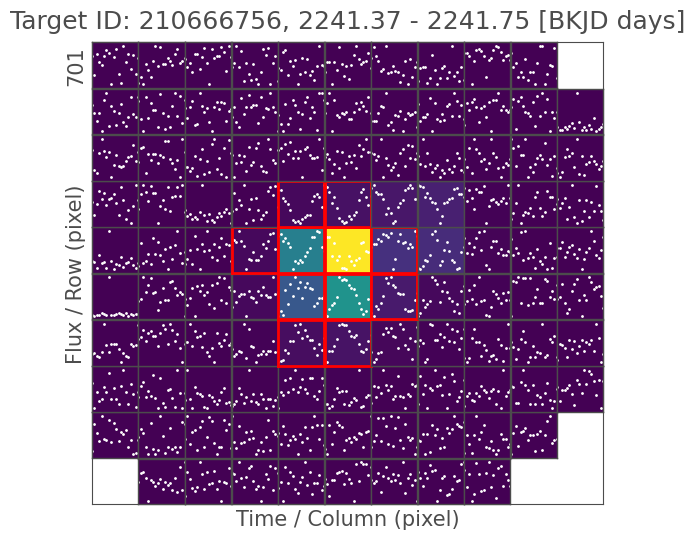

In [29]:
t0 = epoch_time_bkjd - period * 1700  # pick one of the dips in , * 1705 also looks okay
tpf_trunc = lke.truncate(tpf, t0 - 0.2, t0 + 0.2);
# ax = tpf_trunc.to_lightcurve().scatter(label=f"t0: {t0}");

pixel_size_inches, markersize = 0.6, 2
ax = tplt.lk_ax(figsize=(tpf_trunc.flux[0].shape[1] * pixel_size_inches, tpf_trunc.flux[0].shape[0] * pixel_size_inches))
tpf_trunc.plot_pixels(ax=ax, markersize=markersize, show_flux=True, aperture_mask="pipeline");